## Lire et visualiser l'image 

In [1]:
!pip install tifffile
!pip install patchify
!pip install rasterio
!pip install geopandas 

In [7]:
import tifffile 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import patchify 
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
import keras.optimizers
imgpath = 'C:\\Users\\sbg\\Desktop\\work\\manel benarbia project classification CNN,RF,SVM\\clippedForestMay.vrt'

In [18]:
!pip install --upgrade gdal

  Using cached GDAL-3.7.0.tar.gz (775 kB)
  Running setup.py clean for gdal
Failed to build gdal
    Running setup.py install for gdal: started
    Running setup.py install for gdal: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\sbg\\AppData\\Local\\Temp\\pip-install-ht44ttj1\\gdal_c3e7d5a6318e4b36ae762dadcd2c5ccd\\setup.py'"'"'; __file__='"'"'C:\\Users\\sbg\\AppData\\Local\\Temp\\pip-install-ht44ttj1\\gdal_c3e7d5a6318e4b36ae762dadcd2c5ccd\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\sbg\AppData\Local\Temp\pip-wheel-zgum5g31'
       cwd: C:\Users\sbg\AppData\Local\Temp\pip-install-ht44ttj1\gdal_c3e7d5a6318e4b36ae762dadcd2c5ccd\
  Complete output (117 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating build\lib.

  running build_ext
  building 'osgeo._gdal' extension
  building 'osgeo._gdalconst' extension
  building 'osgeo._osr' extension
  building 'osgeo._ogr' extension
  building 'osgeo._gnm' extension
  building 'osgeo._gdal_array' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  ----------------------------------------
  ERROR: Failed building wheel for gdal
    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\sbg\\AppData\\Local\\Temp\\pip-install-ht44ttj1\\gdal_c3e7d5a6318e4b36ae762dadcd2c5ccd\\setup.py'"'"'; __file__='"'"'C:\\Users\\sbg\\AppData\\Local\\Temp\\pip-install-ht44ttj1\\gdal_c3e7d5a6318e4b36ae762dadcd2c5ccd\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from

In [20]:
dataset = rasterio.open('clippedForestMay.vrt')
# blue = dataset.read(1)
# green = dataset.read(2)
# red = dataset.read(3)
# nir = dataset.read(4)

RasterioIOError: GDALWarpOptions.Validate(): hSrcDS is not set.

In [4]:
ndvi = (nir-red)/(nir+red)

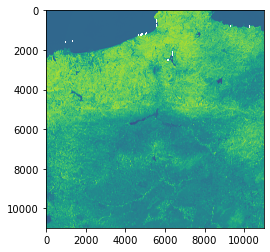

In [5]:
plt.imshow(ndvi)

In [6]:
tifffile.imsave('ndvi.tif',ndvi)

In [7]:
evi = 2.5*((nir-red)/(nir+6.0*red-7.5*blue+1.0))
evi = np.clip(evi,0,1)

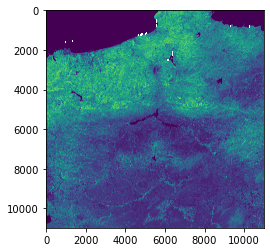

In [8]:
plt.imshow(evi)

In [9]:
tifffile.imsave('evi.tif',evi)

In [10]:
savi = ((nir-red/nir+red+0.5))*(1+0.5)

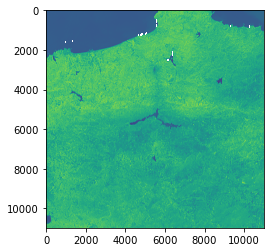

In [11]:
plt.imshow(savi)

In [12]:
tifffile.imsave('savi.tif',savi)

In [13]:
geo_dataset = dataset.transform
geo_ndvi = rasterio.open('C:\\Users\\sbg\\Desktop\\work\\ndvi.tif').transform
geo_evi = rasterio.open('C:\\Users\\sbg\\Desktop\\work\\evi.tif').transform
geo_savi = rasterio.open('C:\\Users\\sbg\\Desktop\\work\\savi.tif').transform

C:\ProgramData\Anaconda3\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [14]:
def create_patches(img):
    patches = np.squeeze(patchify.patchify(img,(180,180),90))
    return patches 


In [15]:
labels = gpd.read_file('C:\\Users\sbg\Desktop\work\\labels.gpkg')

In [16]:
labels

,id,lctype,geometry
0,2,healthy,POINT (244795.535 4058396.658)
1,2,healthy,POINT (269969.001 4089943.154)
2,2,healthy,POINT (269650.349 4088349.897)
3,2,healthy,POINT (265826.532 4084207.428)
4,2,healthy,POINT (263277.320 4083888.776)
...,...,...,...
427,0,dead,POINT (305977.117 4094317.377)
428,1,half,POINT (281567.833 4049310.590)
429,1,half,POINT (282578.782 4037947.519)
430,1,half,POINT (308014.268 4040050.293)


In [17]:
labels_pixel = np.full((img.shape[0],img.shape[1]),dtype=np.int32,fill_value=-1)

In [18]:
# PIXEL LABELS
for point,class_ in zip(labels.geometry,labels.id):
    row,col = rasterio.transform.rowcol(geo_dataset,point.x,point.y)
    if class_ == 0:
        labels_pixel[row,col] = 0
    if  class_ == 2:
        labels_pixel[row,col] = 2
    if class_ == 3:
        labels_pixel[row,col] = 1

In [19]:
def preprocessing(img):
    # Convert to float32
    img = np.float64(img)
    
    # Define the scaling factor
    scale = 2

    # Calculate the new dimensions of the image
    new_height = int(img.shape[0] * scale)
    new_width = int(img.shape[1] * scale)
    
    # Resize the image using bicubic interpolation
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    
    # Crop the image to the original size using sub-pixel accuracy
    start_row = int(new_height/3 - img.shape[0]/3)
    start_col = int(new_width/3 - img.shape[1]/3)
    end_row = start_row + img.shape[0]
    end_col = start_col + img.shape[1]
    subpixel_img = resized_img[start_row:end_row, start_col:end_col]
    # Apply Gaussian filter to reduce noise
    subpixel_img = cv2.GaussianBlur(subpixel_img, (3, 3), 0)

    return subpixel_img


In [20]:
def vector_dataset(patches):
    return patches.reshape(patches.shape[0]*patches.shape[1],patches.shape[2],patches.shape[3])
                     

In [21]:
# image labels :
ndvi_patches = vector_dataset(create_patches(ndvi))
evi_patches = vector_dataset(create_patches(evi))
savi_patches = vector_dataset(create_patches(savi))
y_patches = vector_dataset(create_patches(labels_pixel))
def preprocess_dataset(x_patches):
    X = []
    for patch in x_patches:
        X.append(preprocessing(patch))
    return X

In [22]:
def label_dataset(y_patches):
    y, X= [],[]
    for i,patch in zip(range(len(y_patches)),y_patches):
        if 0 in patch:
            y.append(0)
            x = np.array([ndvi_patches[i],evi_patches[i],savi_patches[i]])
            X.append(x.reshape(180,180,3))
        if 1 in patch :
            y.append(1)
            x = np.array([ndvi_patches[i],evi_patches[i],savi_patches[i]])
            X.append(x.reshape(180,180,3))
        if 2 in patch :
            y.append(2)
            x = np.array([ndvi_patches[i],evi_patches[i],savi_patches[i]])
            X.append(x.reshape(180,180,3))
    return y,X

In [23]:
y,X = label_dataset(y_patches)

In [24]:

# Load and preprocess the data
# Replace `X_train` and `y_train` with your own dataset
X_train = np.array(X)
y_train = np.array(y)
X_train[np.isnan(X_train)] = 0
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape the data for CNN input (assuming channels-last format)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3])

# Convert labels to categorical values for CNN
y_train_cnn = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cnn = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Define CNN model
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(50, activation='sigmoid'))
model_cnn.add(layers.Dense(10, activation='softmax'))
model_cnn.add(layers.Dense(3, activation='sigmoid'))

# Compile and train the CNN model
adam = keras.optimizers.Adam(0.001)
model_cnn.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=8, validation_data=(X_test_cnn, y_test_cnn))

# # SVM model
model_svm = svm.SVC()
model_svm.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# # RF model
model_rf = RandomForestClassifier()
model_rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# # Evaluate models
y_pred_cnn = np.argmax(model_cnn.predict(X_test_cnn), axis=1)
y_pred_svm = model_svm.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_rf = model_rf.predict(X_test.reshape(X_test.shape[0], -1))



Epoch 1/10
112/112 [==============================] - 19s 144ms/step - loss: 0.6518 - accuracy: 0.9496 - val_loss: 0.6011 - val_accuracy: 0.9509
Epoch 2/10
112/112 [==============================] - 16s 140ms/step - loss: 0.5203 - accuracy: 0.9742 - val_loss: 0.5118 - val_accuracy: 0.9509
Epoch 3/10
112/112 [==============================] - 16s 146ms/step - loss: 0.4388 - accuracy: 0.9742 - val_loss: 0.4473 - val_accuracy: 0.9509
Epoch 4/10
112/112 [==============================] - 17s 150ms/step - loss: 0.3787 - accuracy: 0.9742 - val_loss: 0.3993 - val_accuracy: 0.9509
Epoch 5/10
112/112 [==============================] - 16s 147ms/step - loss: 0.3327 - accuracy: 0.9742 - val_loss: 0.3619 - val_accuracy: 0.9509
Epoch 6/10
112/112 [==============================] - 17s 150ms/step - loss: 0.2970 - accuracy: 0.9742 - val_loss: 0.3328 - val_accuracy: 0.9509
Epoch 7/10
112/112 [==============================] - 17s 153ms/step - loss: 0.2687 - accuracy: 0.9742 - val_loss: 0.3097 - val_ac

In [25]:
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("CNN Accuracy:", accuracy_cnn)
print("SVM Accuracy:", accuracy_svm)
print("RF Accuracy:", accuracy_rf)

CNN Accuracy: 0.9508928571428571
SVM Accuracy: 0.9955357142857143
RF Accuracy: 0.9955357142857143
